# Multi Task Learning shape type, color, position

Implementation of a simple multi task learner with 3 tasks (heads). Shares internal reprezentation between different tasks (hard parameter shareing, see [arXiv](https://arxiv.org/abs/1706.05098)) having the direct benefit of a lighter, faster model with less trainable parameters. 

Steps:
- Create toy database, generate shapes, color it
- Normalize the generated images
- Create the multi task learner Keras functional model, train and test it

Finetine the model:
- freeze some layers, fine tune the position detector
- re-test the network


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2

import os
import glob

USE_GPU = 1

if USE_GPU == 1:    
    configproto = tf.compat.v1.ConfigProto() 
    configproto.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=configproto) 
    tf.compat.v1.keras.backend.set_session(sess)

    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True)

    config.gpu_options.per_process_gpu_memory_fraction = 0.3
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

Num GPUs Available:  1


## Create a toy database
- Input image is 128x128x3 image, generate n samples (rectangles/circles, triangles with different size) store it in a numpy array
- Compute the center points, store it together with shape type and color


In [2]:
samples = 2500
w,h = 128,128
obj_min_size = 30
obj_max_size = 60
nr_shape_type = 3
nr_shape_color = 6
stype_lab = ['circle','rectangle', 'triangle']
scolor_lab = ['Red','Green','Blue','Yellow','Pink', 'Cyan']


def gen_traning_data(samples_nr=1000, iw=128,ih=128,obj_min=30,obj_max=60):
    """ generate traning data - rectangles with different size, return img and position"""
    
    imgs = np.zeros((samples_nr,iw,ih,3),dtype=np.uint8)
    pos = np.zeros((samples_nr,2))
    shapetype = np.zeros((samples_nr,3))
    shapecolor = np.zeros((samples_nr,6))
    colors = [[255,0,0],[0,255,0],[0,0,255],[255,255,0],[255,0,255],[0,255,255]]
    
    # encode the colors
    def one_hot(val):
        arr = [0,0,0,0,0,0]
        arr[val] = 1
        return arr
            
    # generate random samples
    for i in range (samples_nr):
        # generate basic shape information
        ow = np.random.randint(obj_min,obj_max,dtype=np.uint8)
        oh = np.random.randint(obj_min,obj_max,dtype=np.uint8)
        oposx = np.random.randint(int(ow/2),iw-ow,dtype=np.uint8)
        oposy = np.random.randint(int(oh/2),ih-oh,dtype=np.uint8)
        
        samples = (np.random.random(size=(iw,ih,3)) *1000).astype(np.ubyte)
        b_kernel = np.dot(np.random.choice([3,5,7,9,11,13,17]),np.array([1,1]))

        samples = cv2.blur(samples,tuple(b_kernel))
        
        imgs[i] += samples
        
        # generate random between [0,5]
        clord = np.random.randint(0,6,dtype=np.uint8)
        color = colors[clord]

        # 0 - circle, 1 - retangle , 2 - triangle
        k = np.random.randint(0,3,dtype=np.uint8)

        if k == 0:
            r = int(min(ow/2,oh/2))
            cv2.circle(imgs[i],(oposx,oposy),r,color,-1)
            pos[i,] = oposx,oposy
            shapetype[i,] = np.array([1,0,0])
            shapecolor[i,]= one_hot(clord)
        elif k==1:
            cv2.rectangle(imgs[i],(oposx,oposy),(oposx+ow,oposy+oh),color,-1)
            pos[i,] = oposx + int(ow/2),oposy + int(oh/2)
            shapetype[i,] = np.array([0,1,0])
            shapecolor[i,]= one_hot(clord)
        elif k==2:
            triangle_points= np.array([[oposx,oposy],[oposx+ow,oposy],[oposx,oposy+oh]],dtype=np.int32)
            cv2.drawContours(imgs[i], [triangle_points], 0, color, -1)
            pos[i,] = int(oposx+ow/4), int(oposy+oh/4)
            shapetype[i,] = np.array([0,0,1])
            shapecolor[i,]= one_hot(clord)
                         
    return imgs,pos,shapetype,shapecolor

imgs,pos,shapetype,shapecolor = gen_traning_data(samples_nr=samples,iw=w,ih=h,obj_min=obj_min_size,obj_max=obj_max_size)

print (imgs.shape,pos.shape)

(2500, 128, 128, 3) (2500, 2)


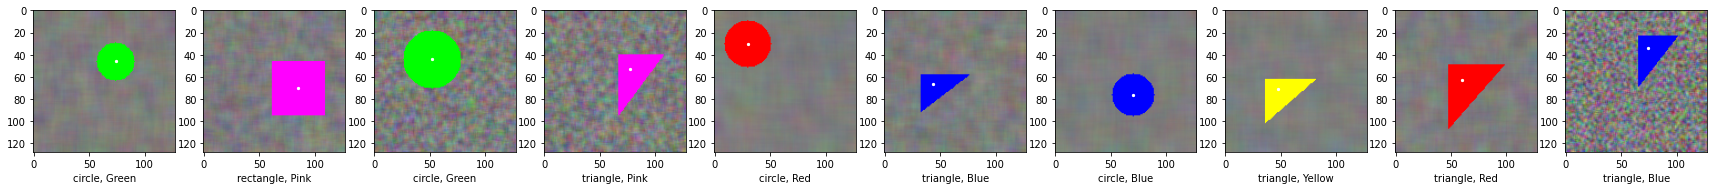

In [3]:
def plot_data(indx,imgarr,posarr,shapetype=None, shapecolor=None):
    #plot image, plt keypoints
    plt.rcParams["figure.figsize"] = (30,8)
    if indx is not None:
        plt.imshow(imgarr[indx], cmap='Greys')
        plt.scatter(posarr[indx,0], posarr[indx,1],s=20, marker='.', c='w')
    else:
        # draw a array of plots
        fig, axs = plt.subplots(1, len(imgarr))
        
        for i, ax in enumerate(axs):
            ax.imshow(imgarr[i])
            if shapetype is not None and shapecolor is not None:
                max_pos = np.argmax(shapetype[i], axis=0)
                st_l = stype_lab[max_pos]
                
                max_pos = np.argmax(shapecolor[i], axis=0)
                sc_l = scolor_lab[max_pos]
                ax.set_xlabel(str(st_l + ", " + sc_l))
                
                
            ax.scatter(posarr[i,0], posarr[i,1],s=20, marker='.', c='w')

# generate 10 samples
plot_data(None,imgs[0:10],pos[0:10],shapetype[0:10],shapecolor[0:10])

## Create a fuctional keras model

Inpus are:
- image -  nx128x128x3
Output:
 - position
 - shape type
 - color

Preprocess:
- before processing the image will be normalized, (0,255)->(0,1)
- positional information will be normalized beteen (128,128)->(0,1)
- split created data to train and validation

In [4]:
# normalize images
X = (imgs.reshape(samples,-1))/255.

# normalize position information
y_pos = pos.reshape(samples,-1) / h

# normalize shape type info
y_type = shapetype

# normalize color info
y_color = shapecolor

# print shapes values
X.shape, y_pos.shape, y_type.shape,y_color.shape, np.mean(imgs), np.std(imgs)

((2500, 49152),
 (2500, 2),
 (2500, 3),
 (2500, 6),
 125.00815262044271,
 39.661675871868006)

In [5]:
# create the DNN functinal model
image_in = keras.layers.Input(shape=(w,h,3))

#Multi task Learning, hard parameter shareing
xhp = keras.layers.Conv2D(32,(10,10)) (image_in)
xhp = keras.layers.BatchNormalization()(xhp)
xhp = keras.layers.Activation('relu')(xhp)
xhp = keras.layers.MaxPool2D(2,2)(xhp)

xhp = keras.layers.Conv2D(64,(3,3)) (xhp)
xhp = keras.layers.BatchNormalization()(xhp)
xhp = keras.layers.Activation('relu')(xhp)
xhp = keras.layers.MaxPool2D(2,2)(xhp)

xhp = keras.layers.Conv2D(64,(3,3)) (xhp)
xhp = keras.layers.BatchNormalization()(xhp)
xhp = keras.layers.Activation('relu')(xhp)
xhp = keras.layers.MaxPool2D(2,2)(xhp)

xhp = keras.layers.Conv2D(128,(2,2)) (xhp)
xhp = keras.layers.BatchNormalization()(xhp)
xhp = keras.layers.Activation('relu')(xhp)
xhp = keras.layers.MaxPool2D(2,2)(xhp)

xhp = keras.layers.Conv2D(32,(3,3)) (xhp)
xhp = keras.layers.BatchNormalization()(xhp)
xhp = keras.layers.Activation('relu')(xhp)
xhp = keras.layers.MaxPool2D(2,2)(xhp)

xhp = keras.layers.Conv2D(64,(3,3), padding="same") (xhp)
xhp = keras.layers.BatchNormalization()(xhp)
xhp = keras.layers.Activation('relu')(xhp)
xhp = keras.layers.MaxPool2D(2,2,  padding="same")(xhp)

# coordinte prediction head
#---------------------

xi = keras.layers.Conv2D(32,(4,4), padding="same", name="cop_conv2d") (xhp)
#xi = keras.layers.BatchNormalization(name="cop_bn")(xi)
xi = keras.layers.Activation('relu', name="cop_act")(xi)
xi = keras.layers.MaxPool2D(2,2,padding="same", name="cop_mp")(xi)

xi = keras.layers.Flatten(name="cop_fl")(xi)

xi = keras.layers.Dense(100, use_bias=True, name="cop_dense")(xi)


out_pos = keras.layers.Dense(2, use_bias=True,  name='cop_pos')(xi)
# ------------------------
# end coordinte prediction head

# shape type prediction head
# ------------------

xt = keras.layers.Flatten(name="st_fl")(xhp)
xt = keras.layers.Dropout(0.5,name="st_drop")(xt)
xt = keras.layers.Dense(4, activation='relu', name="st_dense")(xt)

out_stype = keras.layers.Dense(3,  name='st_stype', activation='softmax')(xt)
# ----------------------
# end shape type prediction head

# color prediction head 
# -------------

xc = keras.layers.Flatten(name="sc_fl")(xhp)
xc = keras.layers.Dropout(0.7, name="sc_drop")(xc)
xc = keras.layers.Dense(4, activation='relu', name="sc_dense")(xc)

out_scolor = keras.layers.Dense(6,name='sc_scolor',activation='softmax')(xc)
# -----------------
# end color prediction head



model = keras.Model(inputs=image_in, outputs={'cop_pos':out_pos, 'st_stype':out_stype, 'sc_scolor':out_scolor})

keras.utils.plot_model(model,to_file='./info/model.png')

model.compile(optimizer='adam',loss = {'cop_pos':'mae','st_stype':'categorical_crossentropy', 'sc_scolor':'categorical_crossentropy'}, metrics={'cop_pos':'acc','st_stype':'acc','sc_scolor':'acc'})

model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 119, 119, 32) 9632        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 119, 119, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 119, 119, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Train the model

In [6]:
steps=40
valsteps=10
epochs=2000

callbacks = [
    keras.callbacks.EarlyStopping(patience=6,min_delta=0.000001),
    keras.callbacks.ModelCheckpoint(filepath='model.h5',save_best_only=True,verbose=1),
]
print (X.shape)

Xr = X.reshape(len(X),128,128,3)

hist = model.fit(x=Xr,y={'cop_pos':y_pos,'st_stype':y_type,'sc_scolor':y_color}, steps_per_epoch=steps,validation_steps=valsteps,validation_split=0.2, epochs=epochs, batch_size=16,callbacks=callbacks, verbose=1,shuffle=True)

(2500, 49152)
Epoch 1/2000
40/40 [==============================] - ETA: 0s - loss: 3.2567 - cop_pos_loss: 0.1486 - sc_scolor_loss: 1.8782 - st_stype_loss: 1.2300 - cop_pos_acc: 0.6641 - sc_scolor_acc: 0.2891 - st_stype_acc: 0.3766
Epoch 00001: val_loss improved from inf to 3.06211, saving model to model.h5
40/40 [==============================] - 3s 69ms/step - loss: 3.2567 - cop_pos_loss: 0.1486 - sc_scolor_loss: 1.8782 - st_stype_loss: 1.2300 - cop_pos_acc: 0.6641 - sc_scolor_acc: 0.2891 - st_stype_acc: 0.3766 - val_loss: 3.0621 - val_cop_pos_loss: 0.3240 - val_sc_scolor_loss: 1.6435 - val_st_stype_loss: 1.0946 - val_cop_pos_acc: 0.5813 - val_sc_scolor_acc: 0.1688 - val_st_stype_acc: 0.3750
Epoch 2/2000
40/40 [==============================] - ETA: 0s - loss: 2.5080 - cop_pos_loss: 0.0955 - sc_scolor_loss: 1.3348 - st_stype_loss: 1.0777 - cop_pos_acc: 0.7563 - sc_scolor_acc: 0.4484 - st_stype_acc: 0.4375
Epoch 00002: val_loss improved from 3.06211 to 2.88934, saving model to model.h

## Plot train information

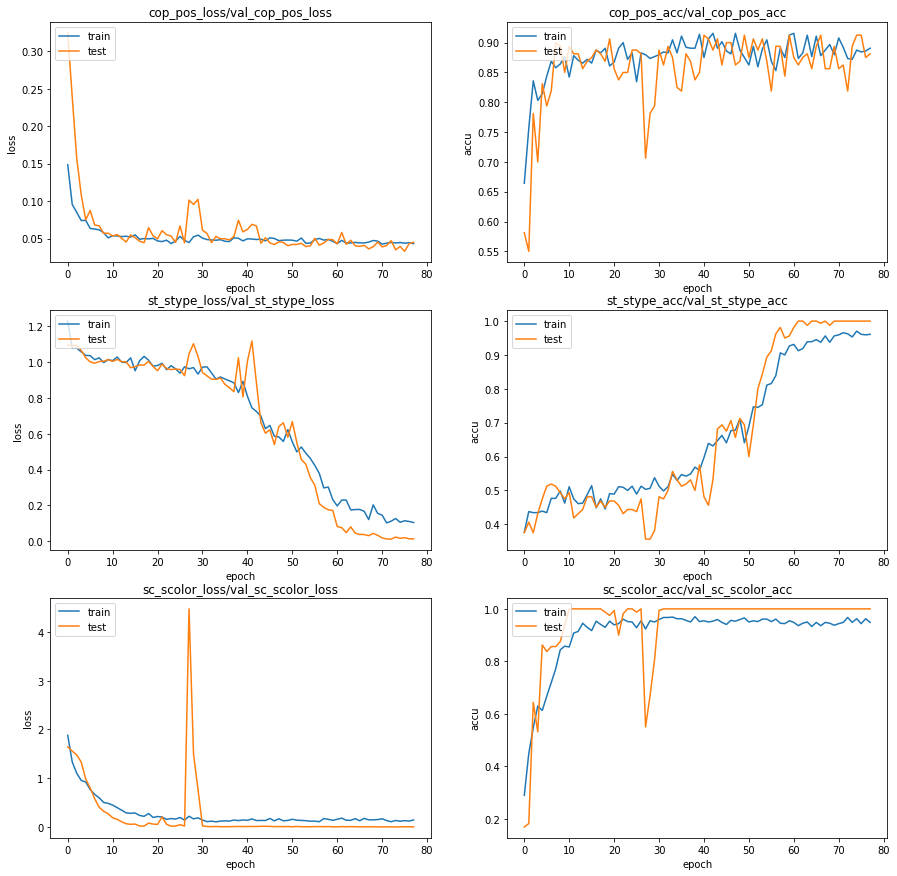

In [7]:
info_accu = [['cop_pos_acc','val_cop_pos_acc'], ['st_stype_acc','val_st_stype_acc'], ['sc_scolor_acc','val_sc_scolor_acc']]
info_loss = [['cop_pos_loss','val_cop_pos_loss'], ['st_stype_loss','val_st_stype_loss'], ['sc_scolor_loss','val_sc_scolor_loss']]

fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(15, 15))

for i in range(3):
    
    #labels
    axs[i,0].set_xlabel("epoch")
    axs[i,0].set_ylabel("loss")
    axs[i,0].set_title(str(info_loss[i][0])+'/'+str(info_loss[i][1]))
    
    axs[i,1].set_xlabel("epoch")
    axs[i,1].set_ylabel("accu")
    axs[i,1].set_title(str(info_accu[i][0]) + "/" + str(info_accu[i][1]))

    # plots
    axs[i,1].plot(hist.history[info_accu[i][0]])
    axs[i,1].plot(hist.history[info_accu[i][1]])
    axs[i,0].plot(hist.history[info_loss[i][0]])
    axs[i,0].plot(hist.history[info_loss[i][1]])

    axs[i,1].legend(['train','test'], loc='upper left')
    axs[i,0].legend(['train','test'],loc='upper left')

 

## Test the trained model

In [26]:
# load traned model
model = keras.models.load_model('model.h5')

tst_nr = 800
ref_tst_img,tst_pos,tst_stype, tst_scolor = gen_traning_data(samples_nr=tst_nr,obj_max=obj_max_size, obj_min=obj_min_size)
tst_pos /=128

# normalize images
X = (ref_tst_img.reshape(tst_nr,-1))/255.

Xr = X.reshape(len(X),128,128,3)


# evaluate the model
print("Model performace on test data...\n")
results = model.evaluate(x=Xr,y={'cop_pos':tst_pos,'st_stype':tst_stype,'sc_scolor':tst_scolor}, batch_size=32)
print("test loss, test acc:", results, "\n")

Model performace on test data...

25/25 [==============================] - 1s 29ms/step - loss: 0.0545 - cop_pos_loss: 0.0388 - sc_scolor_loss: 0.0012 - st_stype_loss: 0.0145 - cop_pos_acc: 0.9125 - sc_scolor_acc: 1.0000 - st_stype_acc: 0.9975
test loss, test acc: [0.0545441210269928, 0.03884786739945412, 0.0011939730029553175, 0.014502279460430145, 0.9125000238418579, 1.0, 0.9975000023841858] 



(800, 49152) (8, 128, 128, 3)


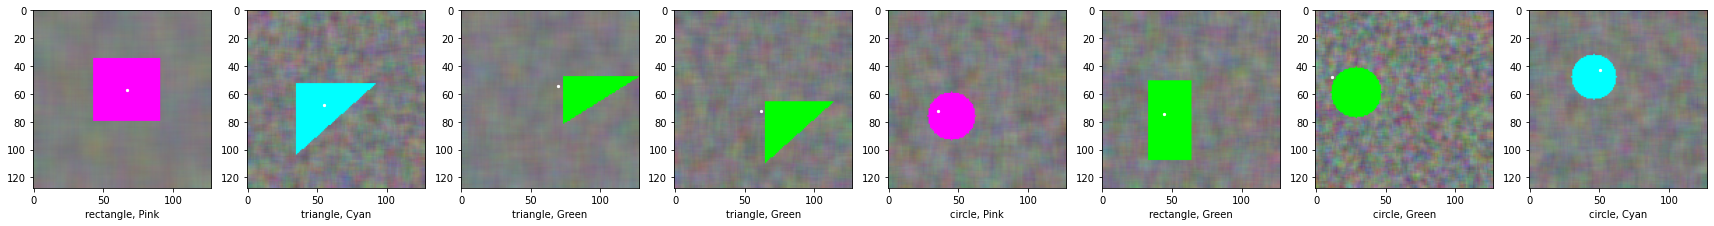

In [27]:
# do some predictions and plot data
print (X.shape, Xr[0:8,:,:,:].shape)
y_pred= model.predict(Xr[0:8,:,:,:])

plot_data(None,ref_tst_img[0:8,:,:,:],y_pred['cop_pos']*128,y_pred['st_stype'],y_pred['sc_scolor'])
plt.savefig('./info/out1.png')

# Generate reports for each head

Head types:
- cop_pos (coordinate predisction) is regrerssion. ``` range x,y = [0,128]``` 
- sc_scolor (shape color) is classification. ```scolor_lab = ['Red','Green','Blue','Yellow','Pink', 'Cyan']```
- st_stype (shape type) is classification. ```stype_lab = ['circle','rectangle', 'triangle']```

Report per head

1. cop_pos mean_absolute_error x,y:  0.04007226256653666 , the best can be 0.0

2. sc_scolor log:               precision    recall  f1-score   support

         Red       1.00      1.00      1.00       128
       Green       1.00      1.00      1.00       149
        Blue       1.00      1.00      1.00       128
      Yellow       1.00      1.00      1.00       116
        Pink       1.00      1.00      1.00       146
        Cyan       1.00      1.00      1.00       133

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



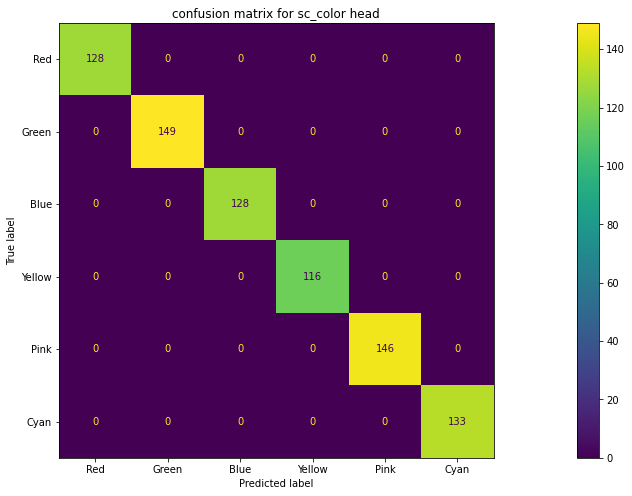

3. st_stype log:               precision    recall  f1-score   support

      circle       1.00      1.00      1.00       278
   rectangle       1.00      1.00      1.00       250
    triangle       1.00      1.00      1.00       272

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



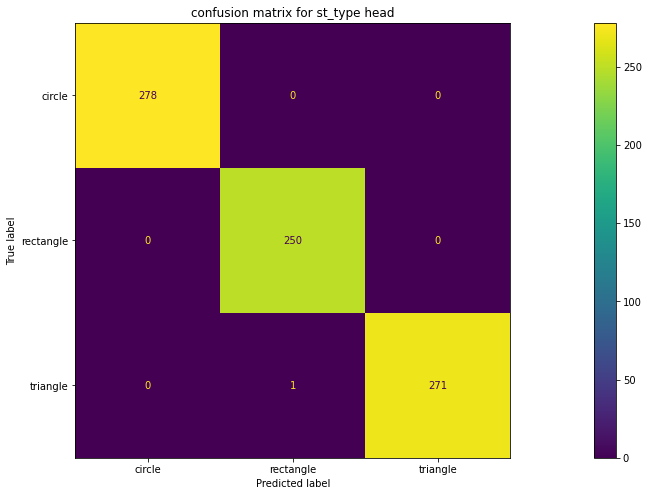

In [10]:
from sklearn.metrics import confusion_matrix,mean_absolute_error,plot_confusion_matrix,ConfusionMatrixDisplay, classification_report

# get prediction results
mret = model.predict(Xr, batch_size=tst_nr)

def generate_reports(tst_pos,tst_scolor,tst_stype, mret):
    y_true_cop_pos = tst_pos
    y_cop_pos_predicted = mret['cop_pos'] # rescaled


    y_predicted_sc_scolor = [scolor_lab[int(np.argmax(val))] for val in mret['sc_scolor']]
    y_true_sc_scolor = [scolor_lab[int(np.argmax(val))] for val in tst_scolor]

    y_predicted_st_stype = [stype_lab[int(np.argmax(val))] for val in mret['st_stype']]
    y_true_st_stype = [stype_lab[int(np.argmax(val))] for val in tst_stype]


    print ("Report per head\n")
    # generate reports
    cop_pos = mean_absolute_error(y_true_cop_pos, y_cop_pos_predicted, multioutput='uniform_average').tolist()
    print ("1. cop_pos mean_absolute_error x,y: ",cop_pos, ", the best can be 0.0\n")

    # display classification results for sc_scolor
    print ("2. sc_scolor log:", classification_report(y_true_sc_scolor,y_predicted_sc_scolor, labels=scolor_lab, zero_division=0))
    cfm_sc_scolor = confusion_matrix(y_true_sc_scolor,y_predicted_sc_scolor,labels=['Red','Green','Blue','Yellow','Pink', 'Cyan']) 
    cfm_sc_color_plot = ConfusionMatrixDisplay(cfm_sc_scolor, display_labels=scolor_lab)    
    cfm_sc_color_plot.plot()
    cfm_sc_color_plot.ax_.set_title("confusion matrix for sc_color head")
    plt.savefig('info/cfm_sc_scolor.png')
    plt.show()
            
    # display classification results for sc_scolor
    print ("3. st_stype log:", classification_report(y_true_st_stype,y_predicted_st_stype, labels=stype_lab))
    cfm_st_stype = confusion_matrix(y_true_st_stype,y_predicted_st_stype) 
    cfm_st_stype_plot = ConfusionMatrixDisplay(cfm_st_stype,display_labels=stype_lab)
    cfm_st_stype_plot.plot()
    cfm_st_stype_plot.ax_.set_title("confusion matrix for st_type head")
    plt.savefig('./info/cfm_sc_stype.png')
    plt.show()
    
generate_reports(tst_pos,tst_scolor,tst_stype, mret)

# Fine tune the trained model

The aim of this step is to improve the regression head performance, while keeping the allready trained base model (feature extractor) and the other heads performance unchanged.

1. freeze the feature extractor part (base model)
2. freeze the shape, color classifiers (2 heads)
3. retrain the position detector (1 head)

> Note: the model contains Batch Normalization, this is needed to be kept in 'inference mode' to do not destroy the feature detector weights


In [11]:
# select a layer to compare, take nr 5:
reference_weights_start = model.layers[5].get_weights()
print ("reference_weights_start shape:", reference_weights_start[0].shape, '\n')

# freeze all layers
for l in model.layers:
        l.trainable = False

train_tag = 'cop_'
# freeze the feature extractor part, 
for l in model.layers:
    if train_tag in l.name:
        l.trainable = True

# verify layers
for i,l in enumerate(model.layers):
    print ("Layer:",i," ",l.name,", Trainable: ", l.trainable)


model.compile(optimizer=keras.optimizers.Adam(1e-5),loss = {'cop_pos':'mae','st_stype':'categorical_crossentropy', 'sc_scolor':'categorical_crossentropy'}, metrics={'cop_pos':'acc','st_stype':'acc','sc_scolor':'acc'})

steps=70
valsteps=10
epochs=100

callbacks = [
    keras.callbacks.EarlyStopping(patience=7,min_delta=0.000001),
    keras.callbacks.ModelCheckpoint(filepath='model_opt.h5',save_best_only=True,verbose=1),
]


hist = model.fit(x=Xr,y={'cop_pos':tst_pos,'st_stype':tst_stype,'sc_scolor':tst_scolor}, steps_per_epoch=steps,validation_steps=valsteps,validation_split=0.2, epochs=epochs, batch_size=16,callbacks=callbacks, verbose=1,shuffle=True)

reference_weights_end = model.layers[5].get_weights()

# if differs, trow an error
np.testing.assert_allclose(reference_weights_start[0], reference_weights_end[0])


reference_weights_start shape: (3, 3, 32, 64) 

Layer: 0   input_1 , Trainable:  False
Layer: 1   conv2d , Trainable:  False
Layer: 2   batch_normalization , Trainable:  False
Layer: 3   activation , Trainable:  False
Layer: 4   max_pooling2d , Trainable:  False
Layer: 5   conv2d_1 , Trainable:  False
Layer: 6   batch_normalization_1 , Trainable:  False
Layer: 7   activation_1 , Trainable:  False
Layer: 8   max_pooling2d_1 , Trainable:  False
Layer: 9   conv2d_2 , Trainable:  False
Layer: 10   batch_normalization_2 , Trainable:  False
Layer: 11   activation_2 , Trainable:  False
Layer: 12   max_pooling2d_2 , Trainable:  False
Layer: 13   conv2d_3 , Trainable:  False
Layer: 14   batch_normalization_3 , Trainable:  False
Layer: 15   activation_3 , Trainable:  False
Layer: 16   max_pooling2d_3 , Trainable:  False
Layer: 17   conv2d_4 , Trainable:  False
Layer: 18   batch_normalization_4 , Trainable:  False
Layer: 19   activation_4 , Trainable:  False
Layer: 20   max_pooling2d_4 , Trainabl

## Evaluate fine tuned model

Model performace on test data...

25/25 [==============================] - 1s 29ms/step - loss: 0.0414 - cop_pos_loss: 0.0257 - sc_scolor_loss: 0.0012 - st_stype_loss: 0.0145 - cop_pos_acc: 0.9425 - sc_scolor_acc: 1.0000 - st_stype_acc: 0.9975
test loss, test acc: [0.0413738451898098, 0.02567758597433567, 0.0011939730029553175, 0.014502279460430145, 0.9424999952316284, 1.0, 0.9975000023841858] 

Report per head

1. cop_pos mean_absolute_error x,y:  0.49087477133107316 , the best can be 0.0

2. sc_scolor log:               precision    recall  f1-score   support

         Red       1.00      1.00      1.00       124
       Green       1.00      1.00      1.00       127
        Blue       1.00      1.00      1.00       132
      Yellow       1.00      1.00      1.00       124
        Pink       1.00      1.00      1.00       141
        Cyan       1.00      1.00      1.00       152

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       80

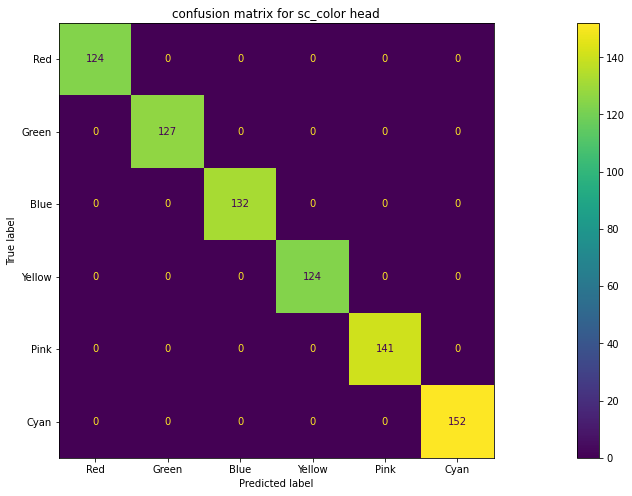

3. st_stype log:               precision    recall  f1-score   support

      circle       1.00      0.99      1.00       250
   rectangle       1.00      1.00      1.00       271
    triangle       1.00      1.00      1.00       279

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



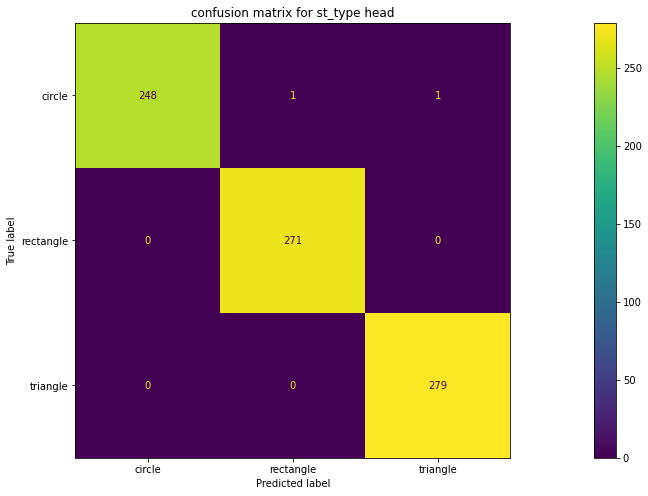

In [29]:
model = keras.models.load_model('model_opt.h5')

# evaluate the model
print("Model performace on test data...\n")
results = model.evaluate(x=Xr,y={'cop_pos':tst_pos,'st_stype':tst_stype,'sc_scolor':tst_scolor}, batch_size=32)
print("test loss, test acc:", results, "\n")

mret = model.predict(Xr, batch_size=tst_nr)

mret['cop_pos'] /=128 

generate_reports(tst_pos,tst_scolor,tst_stype, mret)

## Draw predictions

(800, 49152) (10, 128, 128, 3) (8, 2) (8, 3) (8, 6)


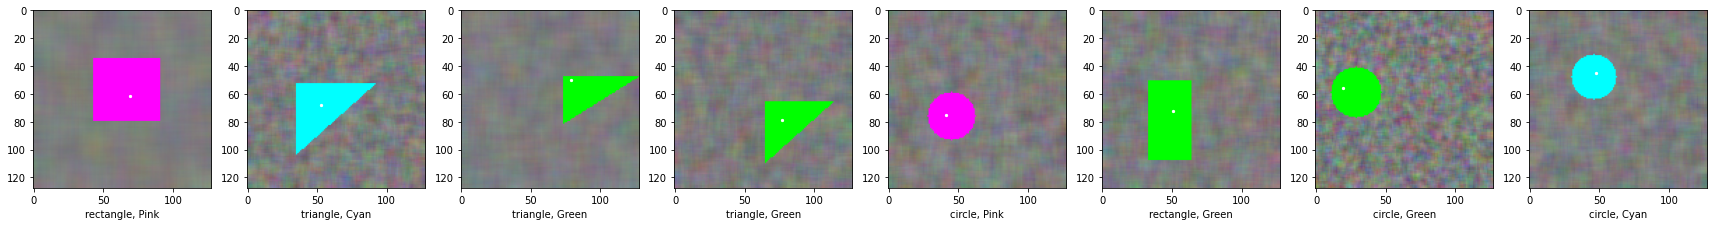

In [30]:
y_pred= model.predict(Xr[0:8,:,:,:])
print (X.shape, Xr[0:10,:,:,:].shape, y_pred['cop_pos'].shape,y_pred['st_stype'].shape, y_pred['sc_scolor'].shape)

# generate 10 samples
plot_data(None,ref_tst_img[0:8],y_pred['cop_pos'][0:8]*128,y_pred['st_stype'],y_pred['sc_scolor'])
plt.savefig('./info/out2.png')